# Brewing Chemistry

This project was completed as the final Phase 5, Capstone assessment in the Flatiron School’s Data Science Bootcamp.

Analysis by Erin Wasserman, July 2024

# Kaggle Overview

This dataset presents an extensive collection of data from a craft beer brewery, spanning from January 2020 to January 2024. It encapsulates a rich blend of brewing parameters, sales data, and quality assessments, providing a holistic view of the brewing process and its market implications.

# Business Problem

In the beer market, demand plays a key role in future industry dynamics. The introduction of new ingredients and innovative flavors into the beer market, combined with a business model that values consumer loyalty, will increase appeal among generations.

The main goal of any brewery is to focus on producing high quality beer. **Quality beer is a key success factor.** The most important thing a brewery can do is keep producing quality beer to stay competitive. As the variety of beers on the market increases, low-quality beers will be eliminated first.

1. Determine best malt and hops types for quality beer.
2. Assess malt-to-hops ratio impact on beer quality.
3. Evaluate ML accuracy in predicting beer characteristics.
4. Visualize beer styles based on quality ratings.

# Data Understanding


**Dataset Description**

[Kaggle Dataset](https://www.kaggle.com/datasets/ankurnapa/brewery-operations-and-market-analysis-dataset/data) <br>

<u>Data Format and Structure:</u><br>
-The dataset is structured in a tabular format, provided in a CSV file for easy integration with various data analysis tools.<br>
-It comprises over 10 million records, each representing a unique batch with a comprehensive set of features.

<u>Intended Audience:</u><br>
This dataset is invaluable for data scientists, brewing process engineers, market analysts, supply chain experts, and quality control professionals in the brewing industry. It is also highly relevant for academic research in food technology, fermentation science, and business analytics.

<u>Disclaimer:</u><br>
-The data is synthetic and intended for educational, analytical, and simulation purposes.<br>
-Users are advised to apply appropriate data processing and analysis techniques for meaningful insights.<br>
-This comprehensive dataset serves as a rich resource for exploring the intricacies of brewing science, market dynamics, and operational efficiency in the craft beer industry.

**Highlighted Data Features**

<u>Brewing Parameters:</u> Includes crucial brewing factors such as fermentation time, temperature, pH level, gravity, and ingredient ratios. These parameters are pivotal in understanding the brewing process and its impact on the final product.

<u>Beer Styles:</u> The dataset categorizes beers into various styles like IPA, Stout, Lager, etc.

<u>Quality Scores:</u> Each batch is rated for its quality on a scale, offering insights into the success and consistency of different brewing approaches.

<u>Application:</u>
Brewing Process Optimization: Ideal for analysis aiming to correlate brewing techniques with beer quality, facilitating the optimization of brewing conditions for superior product quality.

# Import Libraries, Packages, and Environments

In [1]:
%%capture

import time
# Start the timer
start_time = time.time()

#Install Packages
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install pyspark==3.0.1 #Big data processing
!pip install tensorflow==2.8.0 #2.5.0 #machine learning
!pip install --upgrade keras #neural net/deep learning modeling
!pip install elephas==0.4.3 #intergates TensorFlow/Keras with Spark
!pip install chempy #chemistry related calculations
!pip install xgboost #machine learning for large datasets
!pip install numba #to speed up computations on heavy metrics

#Import libraries for system operations and environment management
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow warnings

import sys
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

# To retrieve info on system usage
import psutil

import warnings
# Suppress only specific warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Suppress UserWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)  # Suppress DeprecationWarnings

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

In [2]:
#Verify version for dependencies
import tensorflow as tf
import keras
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("Python version:")
print(sys.version)
print()

TensorFlow version: 2.8.0
Keras version: 2.8.0
Python version:
3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0]



In [10]:
# Start the timer
start_time = time.time()

# Import the necessary third party packages
from pyspark import SparkContext, SparkConf
#conf = SparkConf().setAppName('Elephas_App').setMaster('local[8]')
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.regression import GBTRegressor
from pyspark.sql.types import IntegerType, FloatType, DoubleType
from pyspark.sql import functions as F
from pyspark.sql.functions import col, when, count, split, lit, udf
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import PCA, StandardScaler
from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql import Window
from pyspark.sql.functions import expr, broadcast

import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from google.colab import files
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import plot_tree
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import xgboost as xgb
from xgboost import DMatrix
from numba import jit
import zipfile
import glob
import joblib

from chempy.kinetics.ode import get_odesys
from chempy.kinetics.rates import MassAction
from chempy import Equilibrium, Substance
from scipy.optimize import fsolve
from collections import defaultdict
from chempy.chemistry import Species
from chempy.equilibria import EqSystem
from math import log10

# TensorFlow and Keras for deep learning (for future work)
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, serialize
from tensorflow.keras.utils import *
from tensorflow.python.keras.utils import *

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from elephas.utils.rdd_utils import to_simple_rdd
from elephas.spark_model import SparkModel
from elephas.ml_model import ElephasEstimator
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import serialize

# Set seaborn style for better visualizations
sns.set(style="whitegrid")

# Define your custom color palette using hex codes
custom_colors = ["#f7e1a1", "#e9ad3f", "#d98416", "#b74d00", "#9f3400", "#811f00", "#5e0e00", "#410500", "#2f0200", "#0d0000"]

# Create a custom colormap based on your custom color palette
custom_cmap = mcolors.ListedColormap(custom_colors)

# Set this custom palette globally for Seaborn
sns.set_palette(custom_colors)

# Set the same custom palette for Matplotlib
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

Data transformation execution time: 0.00 seconds


# Notebook Architecture

The following code blocks establish the general setup architecture for the notebook. The Spark session can be initialized according to the computational resources available. Also, pickle functions are set to ease the computational resources by saving the state of an object to a disk, so that it can be reused later without having to recompute or recreate it.


In [4]:
# Start the timer
start_time = time.time()

# Initialize the SparkConf object
conf = SparkConf()

# Set all the configurations you need
conf.setAppName('Elephas_App') \
    .setMaster('local[8]') \
    .set("spark.driver.maxResultSize", "18g")

#conf = SparkConf().setAppName('Elephas_App').setMaster('local[8]') # keep due to dependencies
#conf = pyspark.SparkConf().set("spark.driver.maxResultSize", "10g")
#sc = SparkContext(conf=conf)

#comment or uncomment the code block that suits your computing architecture

# Initialize Spark session (default)
#spark = SparkSession.builder \
 #   .appName("Beer Quality Analysis") \
 #   .config("spark.sql.shuffle.partitions", "50") \
 #   .config("spark.executor.memory", "4g") \
 #   .config("spark.executor.cores", "4") \
 #   .getOrCreate()

# Initialize Spark session (optimized CPU)
#spark = SparkSession.builder \
 #   .appName("Beer Quality Analysis") \
 #   .config("spark.sql.shuffle.partitions", "50") \
 #   .config("spark.driver.memory", "8g") \
 #   .config("spark.executor.memory", "4g") \
 #   .config("spark.executor.cores", "2") \
 #   .config("spark.driver.maxResultSize", "4g") \
 #   .getOrCreate()

# Initialize the Spark session (optimized T4_GPU)
#spark = SparkSession.builder \
 #   .appName("Beer Quality Analysis") \
 #   .config("spark.sql.shuffle.partitions", "200") \
 #   .config("spark.driver.memory", "16g") \
 #   .config("spark.executor.memory", "8g") \
 #   .config("spark.executor.cores", "4") \
 #   .config("spark.driver.maxResultSize", "8g") \
 #   .config("spark.executor.instances", "1") \
 #   .getOrCreate()

    # Start Spark session with optimized settings for T4 GPU
spark = SparkSession.builder \
    .appName("BeerClustering") \
    .config("spark.sql.shuffle.partitions", "400") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.executor.cores", "4") \
    .config("spark.executor.instances", "4") \
    .getOrCreate()

# Determine the number of cores available
total_cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
print(f"Total number of cores available: {total_cores}")

# Set the parallelism to a reasonable value, e.g., half or all of the available cores
parallelism = min(total_cores, 4)  # Adjust this based on project specific needs and testing

# Print Spark configuration settings
spark.sparkContext.setLogLevel("DEBUG")
spark.sparkContext.setCheckpointDir("/tmp/spark-checkpoints")
print(spark.sparkContext.getConf().getAll())

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


Total number of cores available: 1
[('spark.driver.port', '41319'), ('spark.executor.instances', '4'), ('spark.app.name', 'BeerClustering'), ('spark.executor.id', 'driver'), ('spark.sql.shuffle.partitions', '400'), ('spark.driver.memory', '16g'), ('spark.executor.cores', '4'), ('spark.rdd.compress', 'True'), ('spark.app.id', 'local-1723408481185'), ('spark.serializer.objectStreamReset', '100'), ('spark.master', 'local[*]'), ('spark.executor.memory', '8g'), ('spark.submit.pyFiles', ''), ('spark.submit.deployMode', 'client'), ('spark.driver.host', '6a14fffdb32d'), ('spark.ui.showConsoleProgress', 'true')]
Data transformation execution time: 7.96 seconds


<span><div style="display: https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3" width="40"/>
<font color='#811f00' size='4'>Explanation of Settings:
</font>
<br>
<font color='#811f00'>
**spark.sql.shuffle.partitions:** This setting determines the number of partitions to use when shuffling data for operations such as joins or aggregations. A value of 50 is a recommended starting point for balancing performance and resource utilization.<br>
</br>
**spark.driver.memory:** Allocates 8 GB of memory for the Spark driver, which is the main control node of your Spark application. This setting ensures that the driver has sufficient memory to manage the overall execution of the Spark jobs.<br>
</br>
**spark.executor.memory:** Allocates 4 GB of memory for each Spark executor. Executors are the distributed agents that execute the tasks assigned by the driver. This setting ensures that each executor has adequate memory to perform its tasks efficiently.<br>
</br>
**spark.executor.cores:** Allocates 2 CPU cores for each executor. This configuration helps in parallelizing tasks effectively, allowing the executors to handle multiple tasks concurrently.
<br>
</br>
**spark.driver.maxResultSize:** Sets a limit of 4 GB on the maximum size of results that can be collected to the driver. This prevents out-of-memory errors when collecting large results, ensuring the stability of the Spark application.</font> </div></span>

<span><div style="display: https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3" width="40"/><font color='#811f00'><br>
The following code block defines two functions to save and load models using spark. Pickle and Jiblib were considered and not needed for this project given the other resource constraints. The save_model function saves the model to a file, and the load_model function loads the model from a file. This helps save time by avoiding the need to recreate the model every time.</i></font> </div></span>

In [5]:
# Start the timer
start_time = time.time()

# Directory to save models and checkpoints
model_dir = "/content/Brewing_Chemistry/Models/"
os.makedirs(model_dir, exist_ok=True)

def save_spark_model(model, filename):
    """
    Save a Spark MLlib model.

    Parameters:
    model : pyspark.ml.Model
        The Spark MLlib model to be saved.
    filename : str
        The name of the directory where the model will be saved.

    Returns:
    None
    """
    filepath = os.path.join(model_dir, filename)
    model.save(filepath)
    print(f"Model saved to {filepath}")

def load_spark_model(model_class, filename):
    """
    Load a Spark MLlib model.

    Parameters:
    model_class : type
        The class of the model to be loaded (e.g., RandomForestRegressorModel).
    filename : str
        The name of the directory from which the model will be loaded.

    Returns:
    pyspark.ml.Model
        The loaded Spark MLlib model.
    """
    filepath = os.path.join(model_dir, filename)
    model = model_class.load(filepath)
    print(f"Model loaded from {filepath}")
    return model

def save_spark_dataframe(df, filename):
    """
    Save a Spark DataFrame as a Parquet file.

    Parameters:
    df : pyspark.sql.DataFrame
        The Spark DataFrame to be saved.
    filename : str
        The name of the file where the DataFrame will be saved.

    Returns:
    None
    """
    filepath = os.path.join(model_dir, filename)
    df.write.mode("overwrite").parquet(filepath)
    print(f"DataFrame saved to {filepath}")

def load_spark_dataframe(filename):
    """
    Load a Spark DataFrame from a Parquet file.

    Parameters:
    filename : str
        The name of the file from which the DataFrame will be loaded.

    Returns:
    pyspark.sql.DataFrame
        The loaded Spark DataFrame.
    """
    filepath = os.path.join(model_dir, filename)
    df = spark.read.parquet(filepath)
    print(f"DataFrame loaded from {filepath}")
    return df

def checkpoint_dataframe(df, checkpoint_dir="/tmp/spark-checkpoints"):
    """
    Checkpoint a Spark DataFrame.

    Parameters:
    df : pyspark.sql.DataFrame
        The Spark DataFrame to be checkpointed.
    checkpoint_dir : str
        The directory where the checkpoint will be saved.

    Returns:
    pyspark.sql.DataFrame
        The checkpointed DataFrame.
    """
    spark.sparkContext.setCheckpointDir(checkpoint_dir)
    df_checkpointed = df.checkpoint()
    print(f"DataFrame checkpointed to {checkpoint_dir}")
    return df_checkpointed

# Import Data

This code block is forcused on importing the data using Spark.

In [6]:
#The next code block is focused on importing and processing the data using Spark.
# Start the timer
start_time = time.time()

# Load data set
#beer_sample_set = spark.read.csv('sample_data/beer_sample_set.csv', header=True, inferSchema=True)

# Unzip the file
!unzip /content/sample_data/brewery_dataset.zip -d /content/sample_data/

# Find the path of the unzipped file (assuming there's only one CSV file)
csv_file_path = glob.glob('/content/sample_data/**/*.csv', recursive=True)[0]

# Load the dataset using Spark
beer_sample_set = spark.read.csv(csv_file_path, header=True, inferSchema=True)

# Preview the dataset shape and first few rows
print("Dataset shape: Rows -", beer_sample_set.count(), " Columns -", len(beer_sample_set.columns))
print("Schema of the dataset:")
beer_sample_set.printSchema()

print("First few rows of the dataset:")
beer_sample_set.show(5)  # Show the first 5 rows

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

Archive:  /content/sample_data/brewery_dataset.zip
  inflating: /content/sample_data/brewery_data_complete_extended.csv  
Dataset shape: Rows - 10000000  Columns - 20
Schema of the dataset:
root
 |-- Batch_ID: integer (nullable = true)
 |-- Brew_Date: string (nullable = true)
 |-- Beer_Style: string (nullable = true)
 |-- SKU: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Fermentation_Time: integer (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- pH_Level: double (nullable = true)
 |-- Gravity: double (nullable = true)
 |-- Alcohol_Content: double (nullable = true)
 |-- Bitterness: integer (nullable = true)
 |-- Color: integer (nullable = true)
 |-- Ingredient_Ratio: string (nullable = true)
 |-- Volume_Produced: integer (nullable = true)
 |-- Total_Sales: double (nullable = true)
 |-- Quality_Score: double (nullable = true)
 |-- Brewhouse_Efficiency: double (nullable = true)
 |-- Loss_During_Brewing: double (nullable = true)
 |-- Loss_During_Fe

# Preprocessing

Categorical, numeric, and mixed numeric values to be processed accordingly.

In [7]:
# Start the timer
start_time = time.time()

# Create a copy of the DataFrame to not alter original
beer_copy = beer_sample_set

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")


Data transformation execution time: 0.00 seconds


In [8]:
# Start the timer
start_time = time.time()

# Compute summary statistics
describe_df = beer_copy.describe()

# Show the summary statistics
describe_df.show()

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

+-------+------------------+-------------------+----------+--------+---------------+-----------------+------------------+-------------------+--------------------+-------------------+------------------+-----------------+----------------+-----------------+------------------+------------------+--------------------+-------------------+------------------------+----------------------------+
|summary|          Batch_ID|          Brew_Date|Beer_Style|     SKU|       Location|Fermentation_Time|       Temperature|           pH_Level|             Gravity|    Alcohol_Content|        Bitterness|            Color|Ingredient_Ratio|  Volume_Produced|       Total_Sales|     Quality_Score|Brewhouse_Efficiency|Loss_During_Brewing|Loss_During_Fermentation|Loss_During_Bottling_Kegging|
+-------+------------------+-------------------+----------+--------+---------------+-----------------+------------------+-------------------+--------------------+-------------------+------------------+-----------------+-----

<span><div style="display: https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3" width="40"/><font color='#811f00'>
<br>
Focusing on the column subset related to the chemical properties of beer, the pH seems consistently below 7. The average temperatue slightly below room standard room temperature. The bitterness has a large standard deviation relative to the mean.
<br>
</br>
The standard metric that will be used for this analysis of quality score seems to have a small standard deviation and the scores all seem  to be high in a range of 6-9.99 with an average score of 7.99.</font> </div></span>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

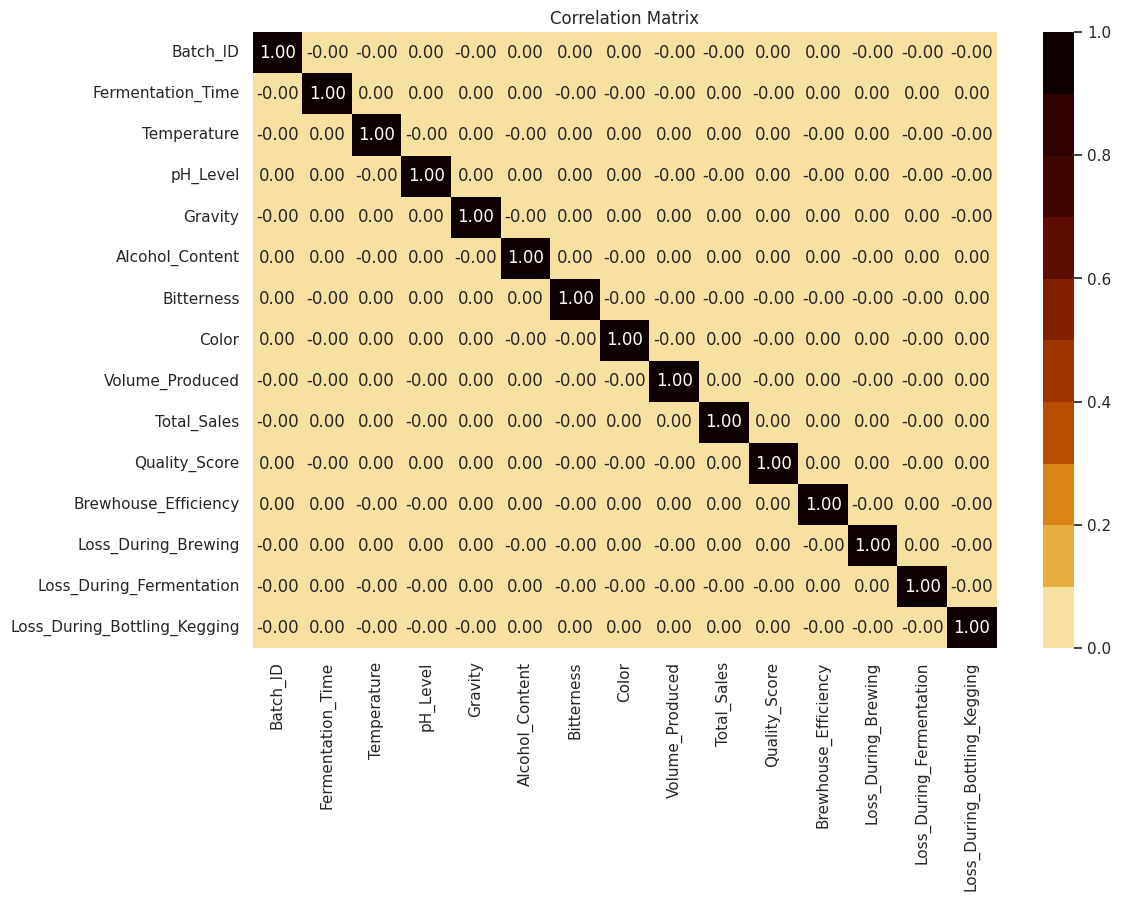

Data transformation execution time: 112.94 seconds


In [11]:
#The code block is responsible for computing the correlation
#matrix for the numeric columns in the beer_copy DataFrame, converting it into
#a Pandas DataFrame for visualization, and then plotting it as a heatmap.

# Cache the DataFrame to avoid recomputation
beer_sample_set.cache()

# Start the timer
start_time = time.time()

# Select numeric columns
numeric_columns = [field.name for field in beer_copy.schema.fields if isinstance(field.dataType, (IntegerType, FloatType, DoubleType))]

# Efficiently compute the correlation matrix using Spark's built-in method
corr_matrix_spark = beer_copy.select(numeric_columns).toPandas().corr()

# Convert Spark's correlation matrix to a Pandas DataFrame
corr_matrix = pd.DataFrame(corr_matrix_spark, index=numeric_columns, columns=numeric_columns)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=custom_cmap)
plt.title('Correlation Matrix')

# Save the plot as an image with better layout
filename = "all_data_correlation_matrix.jpg"
plt.savefig(filename, bbox_inches='tight')

# Download the file
files.download(filename)

# Show the plot
plt.show()

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")


<span><div style="display: https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3" width="40"/><font color='#811f00'><br>
The most notable insight here is that the correlation plot seems to be completely uniform. Processing this data set will be challenging. To discover the relationships will require advanced techniques and deep domain knowledge.</font> </div></span>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 1200x1000 with 0 Axes>

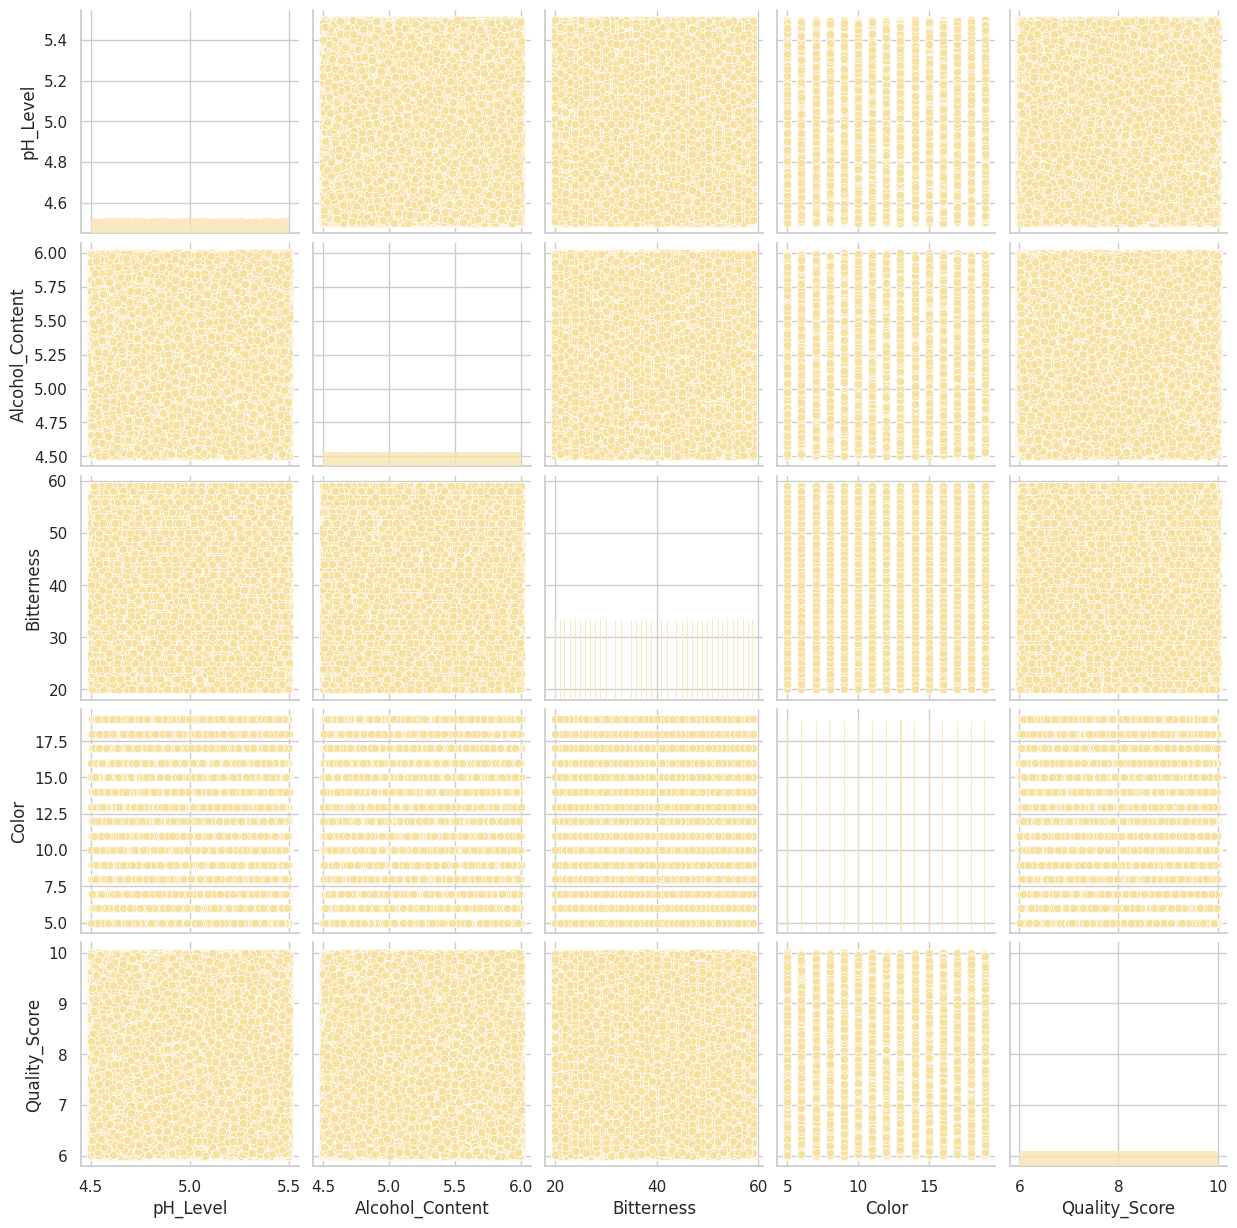

Data transformation execution time: 1269.00 seconds


In [12]:
#This next code block is focused on generating a pair plot for selected
#numerical columns from the beer_copy DataFrame. The key steps include
#converting the Spark DataFrame to a Pandas DataFrame, plotting the pair plot
#using Seaborn, and saving the plot as an image.



# Start the timer
start_time = time.time()

# Select relevant numerical columns
numeric_columns = ['pH_Level', 'Alcohol_Content', 'Bitterness', 'Color', 'Quality_Score']

# Collect the data as a Pandas DataFrame
beer_sample_pandas = beer_copy.select(numeric_columns).toPandas()

## Plot the pair plot
plt.figure(figsize=(12, 10))
sns.pairplot(beer_sample_pandas)

# Save the plot as an image with better layout
filename = "all_data_pair_plot.jpg"
plt.savefig(filename, bbox_inches='tight')

# Download the file
files.download("all_data_pair_plot.jpg")

# Show the plot
plt.show()

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")


<span><div style="display: https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3" width="40"/><font color='#811f00'><br>
This confirms the correlation plot consculsion. These pair plots show flat and uniform data. This shows how important this step in the preprocessing is because without these plots, it wouldn't be so obvious that the data set would be a challenge for finding relationships.</font> </div></span>

In [13]:
#This code block focuses on selecting a subset of the data relevant for feature
#engineering, particularly for predicting beer quality.

# Start the timer
start_time = time.time()

# Define the columns relevant for feature engineering (features that contain chemistry dependent properties)
relevant_columns = ['pH_Level', 'Ingredient_Ratio', 'Fermentation_Time', 'Temperature',
                    'Alcohol_Content', 'Bitterness', 'Color', 'Quality_Score']
categorical_columns = ['Beer_Style']

# Create a subset of the data with relevant columns
beer_quality_predict = beer_copy.select(relevant_columns + categorical_columns)

# Preview the subset of the data
print("Subset of the data with relevant columns:")
beer_quality_predict.show(5)

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

Subset of the data with relevant columns:
+------------------+----------------+-----------------+------------------+-----------------+----------+-----+-----------------+----------+
|          pH_Level|Ingredient_Ratio|Fermentation_Time|       Temperature|  Alcohol_Content|Bitterness|Color|    Quality_Score|Beer_Style|
+------------------+----------------+-----------------+------------------+-----------------+----------+-----+-----------------+----------+
|5.2898454476095615|     1:0.32:0.16|               16|24.204250857069873|5.370842159553436|        20|    5| 8.57701633109399|Wheat Beer|
| 5.275643382756193|     1:0.39:0.24|               13|18.086762947259544|5.096053082797625|        36|   14|7.420540752553908|      Sour|
|4.7780156232459765|     1:0.35:0.16|               12|15.539332669116469|4.824737120959184|        30|   10|8.451364886803127|Wheat Beer|
| 5.345260585546188|     1:0.35:0.15|               17| 16.41848910394318|5.509243080797997|        48|   18|9.6718594040431

<span><div style="display: https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3" width="40"/><font color='#811f00'><br>
This analysis will focus on the chemical properties of the beer making process that lead to top quality scores (https://www.micetgroup.com/the-business-competition-strategy-of-craft-brewery/). So here a chemical properties data subset is formed.</font> </div></span>

In [14]:
#This code block is focused on inspecting the schema and summary statistics
#of the beer_quality_predict DataFrame, which I previously created as a subset
#of relevant columns for predicting beer quality.

# Start the timer
start_time = time.time()

# Show schema of the DataFrame
beer_quality_predict.printSchema()

# Show summary statistics for numerical columns
beer_quality_predict.describe().show()

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")


root
 |-- pH_Level: double (nullable = true)
 |-- Ingredient_Ratio: string (nullable = true)
 |-- Fermentation_Time: integer (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Alcohol_Content: double (nullable = true)
 |-- Bitterness: integer (nullable = true)
 |-- Color: integer (nullable = true)
 |-- Quality_Score: double (nullable = true)
 |-- Beer_Style: string (nullable = true)

+-------+-------------------+----------------+-----------------+------------------+-------------------+------------------+-----------------+------------------+----------+
|summary|           pH_Level|Ingredient_Ratio|Fermentation_Time|       Temperature|    Alcohol_Content|        Bitterness|            Color|     Quality_Score|Beer_Style|
+-------+-------------------+----------------+-----------------+------------------+-------------------+------------------+-----------------+------------------+----------+
|  count|           10000000|        10000000|         10000000|          10000000|  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

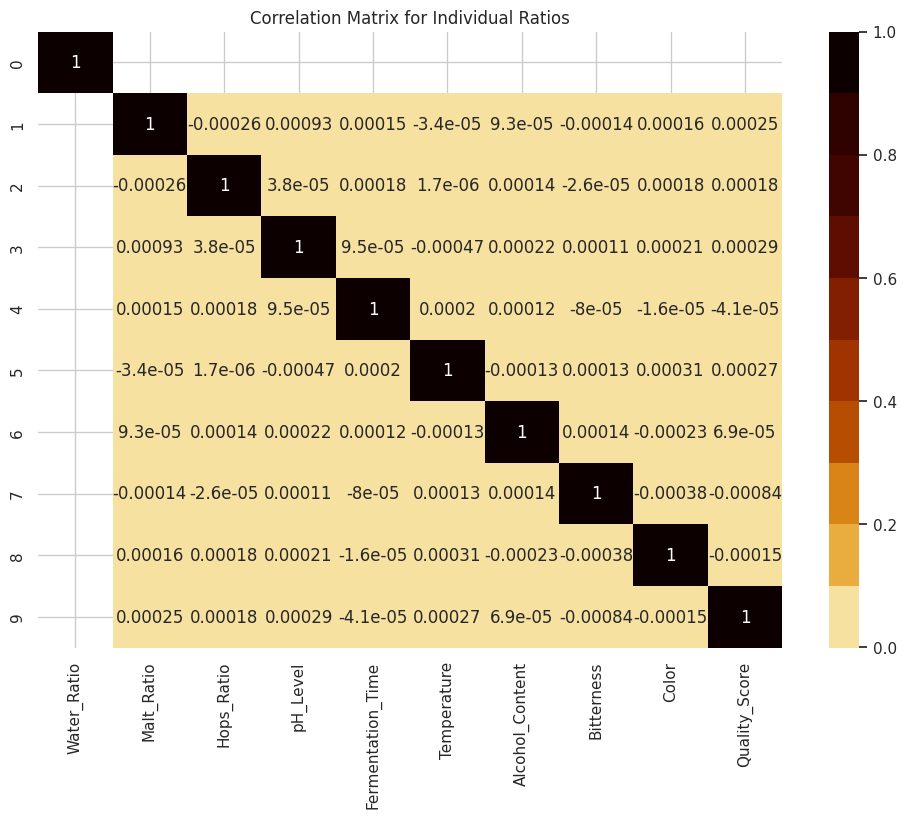

Data transformation execution time: 30.47 seconds


In [15]:
#This code block focuses on extracting individual components from a component ratio
#column, assembling these features into a feature vector, calculating the
#correlation matrix for these features, and then visualizing the results as
#a heatmap.


# Start the timer
start_time = time.time()

# Extract Individual Components
beer_quality_predict = beer_quality_predict.withColumn('Water_Ratio', lit(1.0))
beer_quality_predict = beer_quality_predict.withColumn('Malt_Ratio', split(col('Ingredient_Ratio'), ':').getItem(1).cast('float'))
beer_quality_predict = beer_quality_predict.withColumn('Hops_Ratio', split(col('Ingredient_Ratio'), ':').getItem(2).cast('float'))

# Assemble all relevant features into a vector
vector_col = 'features'
assembler = VectorAssembler(inputCols=['Water_Ratio', 'Malt_Ratio', 'Hops_Ratio', 'pH_Level', 'Fermentation_Time', 'Temperature',
                                       'Alcohol_Content', 'Bitterness', 'Color', 'Quality_Score'], outputCol=vector_col)
df_vector = assembler.transform(beer_quality_predict).select(vector_col)

# Calculate Correlation Matrix
matrix = Correlation.corr(df_vector, vector_col).head()[0]
corr_matrix_indv = pd.DataFrame(matrix.toArray(), columns=['Water_Ratio', 'Malt_Ratio', 'Hops_Ratio', 'pH_Level', 'Fermentation_Time', 'Temperature',
                                                           'Alcohol_Content', 'Bitterness', 'Color', 'Quality_Score'])

# Visualize Correlations
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_indv, annot=True, cmap=custom_cmap)
plt.title('Correlation Matrix for Individual Ratios')

# Save the plot as an image with better layout
filename = "property_data_correlation_matrix.jpg"
plt.savefig(filename, bbox_inches='tight')

# Download the file
files.download("property_data_correlation_matrix.jpg")

# Show the plot
plt.show()

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")


<span><div style="display: https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3" width="40"/><font color='#811f00'><br>
Remarkably uniform. Traditional corelation matrices would show hints of a relationship. In this case, a deep dive into domain knowledge will be used to look closely for any relationships in the raw data.</font> </div></span>

In [16]:
#This code block is focused on creating a new feature, Malt_Hops_Ratio, by
#dividing the Malt_Ratio by the Hops_Ratio.

# Start the timer
start_time = time.time()

# Create Combined Ratio Feature
beer_quality_predict = beer_quality_predict.withColumn('Malt_Hops_Ratio', col('Malt_Ratio') / col('Hops_Ratio'))

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

Data transformation execution time: 0.02 seconds


## Summary
 Given the uniform structure of this data set, let's see if any insights can be learned when applying domain knowledge to the dataset.

 The ingredient ratio of water, malt, and hops is crucial in brewing. Chemistry shows that water forms the base of the mixture, malt provides the sugars needed for fermentation, and hops add bitterness and aroma. Typically, water is present in the highest ratio, followed by malt, with hops being in the smallest ratio. In this next analysis, we will create separate columns for the water, malt, and hops ratios, as well as a new feature column for the malt-to-hops ratio, to better understand their individual and combined effects on beer quality.

# Feature Engineering

We will infer new features based on existing data. The Malt_Type column will be created based on the beer's color, and the Hops_Type column will be derived from the beer's bitterness. These engineered features will then be one-hot encoded to prepare them for machine learning models.

In [17]:
#This code block is focused on feature engineering, where I infer malt and hops
#types from existing features, and then perform one-hot encoding on
#categorical variables.

# Start the timer
start_time = time.time()

# Function to infer malt type from color
beer_quality_predict = beer_quality_predict.withColumn(
    'Malt_Type',
    when(col('Color') < 10, 'Barley')
    .when((col('Color') >= 10) & (col('Color') < 20), 'Wheat')
    .when((col('Color') >= 20) & (col('Color') < 30), 'Rye')
    .otherwise('Oats')
)

# Function to infer hops type from bitterness
beer_quality_predict = beer_quality_predict.withColumn(
    'Hops_Type',
    when(col('Bitterness') > 40, 'Bittering')
    .when((col('Bitterness') > 20) & (col('Bitterness') <= 40), 'Dual Purpose')
    .otherwise('Aroma')
)

# Show the updated DataFrame with the new engineered features
beer_quality_predict.select('Color', 'Malt_Type', 'Bitterness', 'Hops_Type').show(5)

# One-hot encode categorical variables for machine learning models
categorical_columns = ['Beer_Style', 'Malt_Type', 'Hops_Type']

# Create a list to hold the stages of the Pipeline
stages = []

# Loop through each categorical column and create a StringIndexer and OneHotEncoder for each
for colm in categorical_columns:
    indexer = StringIndexer(inputCol=colm, outputCol=colm + '_Index')
    encoder = OneHotEncoder(inputCol=colm + '_Index', outputCol=colm + '_Vec')
    stages += [indexer, encoder]

# Apply the stages of the Pipeline to the DataFrame
pipeline = Pipeline(stages=stages)
beer_encoded = pipeline.fit(beer_quality_predict).transform(beer_quality_predict)

# Show the resulting DataFrame with the one-hot encoded columns
print("One-hot encoded dataframe:")
beer_encoded.select([colm for colm in beer_encoded.columns if 'Vec' in colm]).show()

# Preview the entire DataFrame
beer_encoded.show()

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")


+-----+---------+----------+------------+
|Color|Malt_Type|Bitterness|   Hops_Type|
+-----+---------+----------+------------+
|    5|   Barley|        20|       Aroma|
|   14|    Wheat|        36|Dual Purpose|
|   10|    Wheat|        30|Dual Purpose|
|   18|    Wheat|        48|   Bittering|
|   13|    Wheat|        57|   Bittering|
+-----+---------+----------+------------+
only showing top 5 rows

One-hot encoded dataframe:
+--------------+-------------+-------------+
|Beer_Style_Vec|Malt_Type_Vec|Hops_Type_Vec|
+--------------+-------------+-------------+
|     (7,[],[])|    (1,[],[])|    (2,[],[])|
| (7,[2],[1.0])|(1,[0],[1.0])|(2,[0],[1.0])|
|     (7,[],[])|(1,[0],[1.0])|(2,[0],[1.0])|
| (7,[0],[1.0])|(1,[0],[1.0])|(2,[1],[1.0])|
| (7,[3],[1.0])|(1,[0],[1.0])|(2,[1],[1.0])|
| (7,[0],[1.0])|    (1,[],[])|(2,[1],[1.0])|
| (7,[5],[1.0])|    (1,[],[])|(2,[1],[1.0])|
|     (7,[],[])|    (1,[],[])|(2,[0],[1.0])|
| (7,[3],[1.0])|(1,[0],[1.0])|(2,[0],[1.0])|
| (7,[3],[1.0])|(1,[0],[1.0])|

<span><div style="display: https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3" width="40"/><font color='#811f00'><br>
Using reference literature on beer making, hops and malt types can be inferred based on the beer's color and bitterness. In brewing, the color of the beer, which ranges from pale yellow to dark brown, is primarily influenced by the type and amount of malt used. Malt provides fermentable sugars and contributes to the beer's flavor and body.
<br><br>
Hops, known for their bitterness and aromatic qualities, counterbalance the sweetness of the malt. The bitterness level, often measured in International Bitterness Units (IBUs), indicates the type of hops used. Chemistry plays a crucial role in understanding these properties, as different malts and hops impart specific flavors, aromas, and colors through their unique chemical compositions.
<br><br>
By analyzing these characteristics, brewers can predict the type of malt and hops used in a beer, enabling them to replicate or innovate on traditional recipes.</font> </div></span>

<span><div style="display: https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3" width="40"/><font color='#811f00'><br>The temperature split turned out not to be a useful metric because the category values overlap so Beer_Style cannot be clearly delineated at this point.
<br><br>
Reference:
<br>
1 Ales: 62-75 °F (17-24 °C)
<br>
2 Lagers: 46-58 °F (8-14 °C) #assume dark lagers for this project<br>
3 Wheat and Belgian styles: 62-85 °F (17-29 °C), ales are divided into these categories
<br><br>
Next, let's take a look at whether or not the Beer_Style feature distribute consistently into the Fermentation_Time feature.</font> </div></span>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

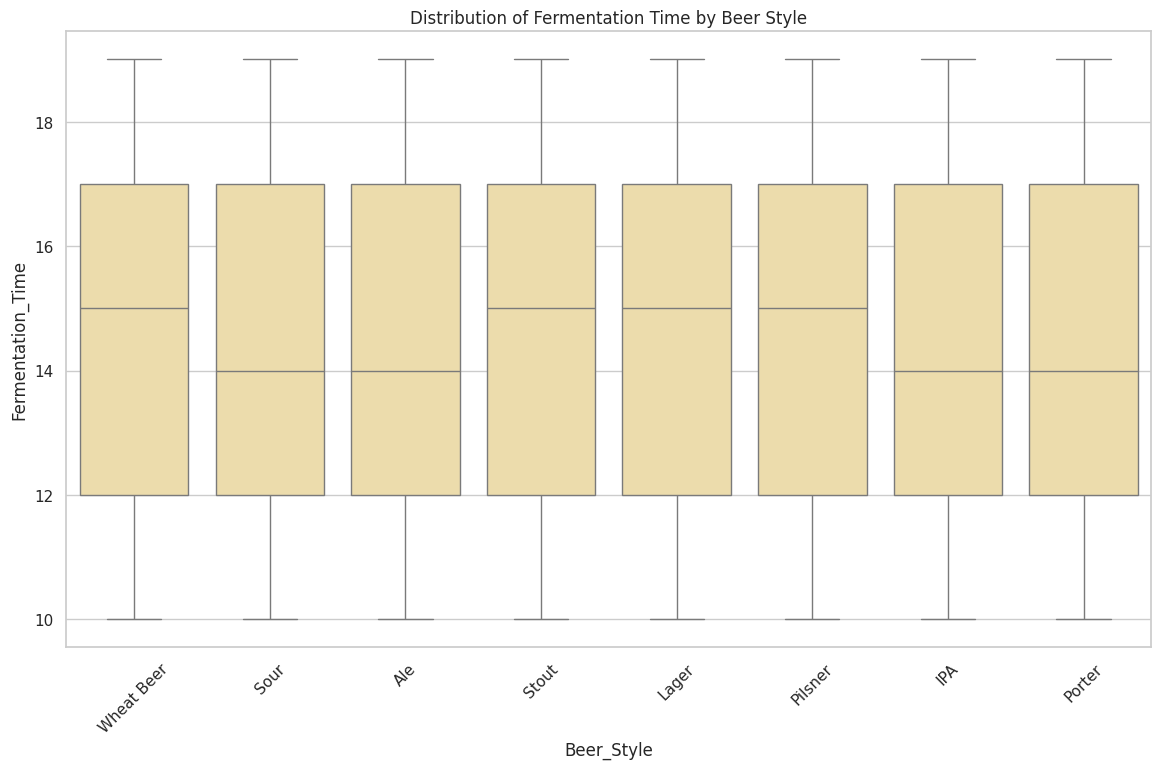

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

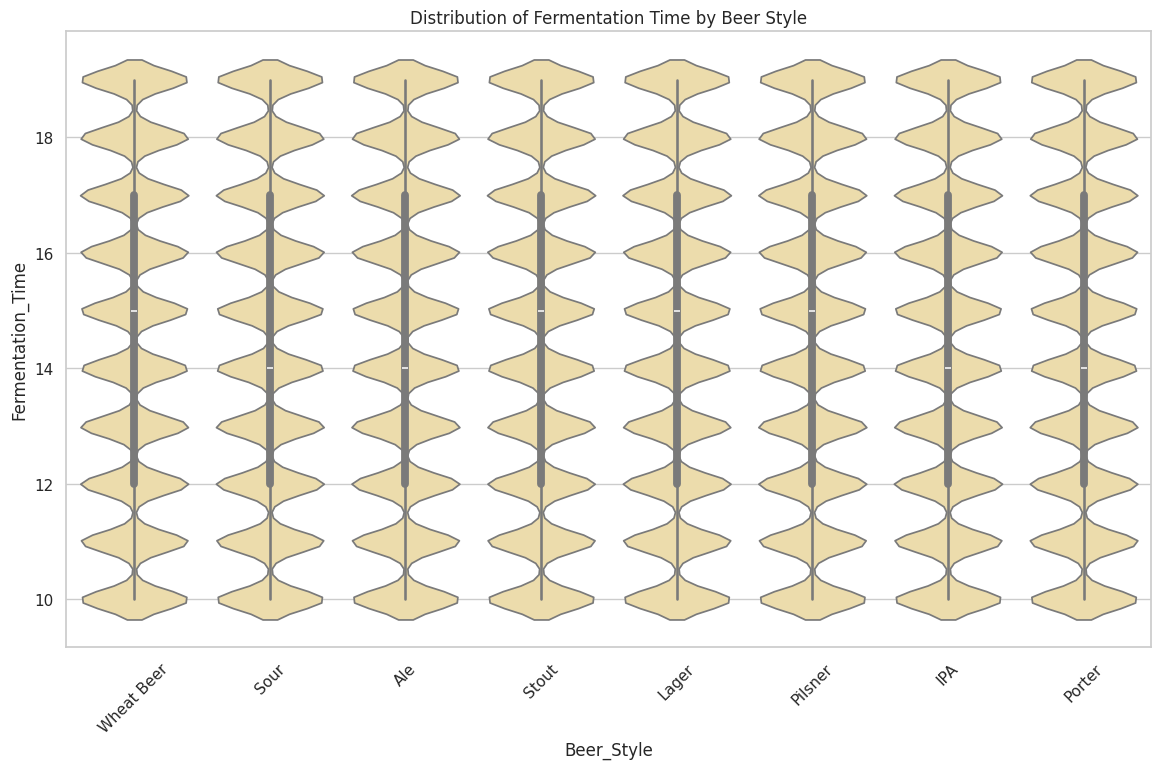

Data transformation execution time: 73.58 seconds


In [18]:
#This code block is focused on visualizing the distribution of fermentation
#time by beer style. It involves creating box plots and violin plots using
#Seaborn.

# Start the timer
start_time = time.time()

# Extract relevant columns
ferment_style_comp = beer_quality_predict.select('Beer_Style', 'Fermentation_Time')

# Convert to Pandas DataFrame for plotting
ferment_style_comp_pd = ferment_style_comp.toPandas()

# Create a box plot
plt.figure(figsize=(14, 8))
sns.boxplot(x='Beer_Style', y='Fermentation_Time', data=ferment_style_comp_pd)
plt.title('Distribution of Fermentation Time by Beer Style')
plt.xticks(rotation=45)

# Save the plot as an image with better layout
filename = "fermentation_style_box_plot.jpg"
plt.savefig(filename, bbox_inches='tight')

# Download the file
files.download("fermentation_style_box_plot.jpg")

# Show the plot
plt.show()

# Create a violin plot
plt.figure(figsize=(14, 8))
sns.violinplot(x='Beer_Style', y='Fermentation_Time', data=ferment_style_comp_pd)
plt.title('Distribution of Fermentation Time by Beer Style')
plt.xticks(rotation=45)

# Save the plot as an image with better layout
filename = "fermentation_style_violin_plot.jpg"
plt.savefig(filename, bbox_inches='tight')

# Download the file
files.download("fermentation_style_violin_plot.jpg")

# Show the plot
plt.show()

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

<span><div style="display: https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3" width="40"/><font color='#811f00'><br><u>Box Plot:</u><br>This box plot shows the distribution of fermentation time across different beer styles. Box plots are useful for visualizing the spread and central tendency of the data, as well as identifying any potential outliers.<br><br>
Here are the box plot key points:<br>
<br><u>X-Axis (Beer Style):</u> Lists the different types of beer styles, such as Wheat Beer, Sour, Ale, Stout, Lager, Pilsner, IPA, and Porter.<br><u>
Y-Axis (Fermentation Time):</u> Represents the fermentation time in days.<br>
<u>Median Fermentation Time:</u> The horizontal line within each box represents the median fermentation time for each beer style. Across the beer styles, the median fermentation time is relatively consistent, ranging between 14 and 16 days.<br>
<u>Interquartile Range (IQR):</u> The boxes represent the middle 50% of the data (from the 25th percentile to the 75th percentile). The IQR for each beer style shows some variation, but overall, most beer styles have an IQR that spans from approximately 13 to 16.5 days.<br>
<u>Whiskers:</u> The lines (whiskers) extending from the boxes indicate the range of fermentation times, excluding outliers. The whiskers suggest that the majority of the fermentation times fall between 10 and 18 days for all beer styles.<br>
<u>Outliers:</u> There do not appear to be any significant outliers in the data, as no points are plotted outside the whiskers.<br>
<u>Conclusion:</u>
The plot shows that while there is some variation in fermentation times across different beer styles, the range is generally consistent. Most beer styles have a median fermentation time around 15 days, with fermentation times ranging from approximately 10 to 18 days. This suggests that fermentation time is relatively standardized across different styles of beer.<br><br><br>
<u>Violin Plot</u><br>
The violin plot shows that fermentation times are relatively consistent across different beer styles, with most styles having a median fermentation time around 15 days. Violin plots combine aspects of box plots and density plots to provide more information about the distribution of data.<br><br>Here are the box plot key points:<br><br>
<u>X-Axis (Beer Style):</u> Lists the different types of beer styles, such as Wheat Beer, Sour, Ale, Stout, Lager, Pilsner, IPA, and Porter.<br><u>
Y-Axis (Fermentation Time):</u> Represents the fermentation time in days.<br>
<u> Distribution Shape:</u> The width of each violin represents the density of data points at different fermentation times for each beer style. Wider sections indicate higher density (more common fermentation times), while narrower sections indicate lower density.<br>
<u>Central Tendency:</u> The white dot in the center of each violin represents the median fermentation time for that beer style. The median is relatively consistent across beer styles, around 15 days.<br>
<u>Range of Fermentation Time:</u> The plots are generally symmetrical, indicating a uniform distribution of fermentation times. The range of fermentation time for most beer styles is between 10 and 18 days.<br>
<u>Density Peaks:</u> Some beer styles show distinct peaks in density, indicating specific fermentation times that are more common. For example, Lager, Pilsner, and IPA show a relatively wider distribution near the median, suggesting a more even spread of fermentation times around the median value.

## Summary
This discrete data is based on all 10 million data points and shows that Lager and IPA have an increased fermentation time due to the chemistry involved. Lager yeasts ferment at lower temperatures and more slowly, allowing for the development of clean, crisp flavors. IPAs, with their higher hop content, require extended fermentation to balance the bitterness and develop the complex hop aromas and flavors through biochemical reactions.

Generally, the plots show that the fermentation times for different beer styles are consistent; with median values around 15-16 days and a range between approximately 10 and 18 days. This is evident from the box plot and violin plot, which both show similar distributions across beer styles. The similar interquartile ranges indicate that the central 50% of the data points for each style lie within a comparable range. The density of data points around the median values, as shown in the violin plot, reinforces this observation.<br><br>
This data suggests that while specific styles like Lager and IPA may have increased fermentation times due to their unique chemistry, the overall process duration is quite uniform across various beer styles.

# Unsupervised Learning

This experiment explores clustering models with a K-means experiment. To determine the optimal cluster grouping number inertia and silhouette scores will be used.

In [ ]:
#This code block is focused on performing K-means clustering on the scaled
#features of the dataset, followed by the evaluation of the optimal number of
#clusters using the elbow method and silhouette scores.

# Start the timer
start_time = time.time()

# Select relevant features for clustering
clustering_features = ['Temperature', 'Fermentation_Time', 'pH_Level', 'Alcohol_Content', 'Bitterness', 'Color']

# Assemble the features into a single vector column
assembler = VectorAssembler(inputCols=clustering_features, outputCol="features")
beer_assembled = assembler.transform(beer_encoded)

# Normalize the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(beer_assembled)
beer_scaled = scaler_model.transform(beer_assembled)

# Cache the scaled DataFrame to speed up clustering iterations
beer_scaled.cache()

# Define the range of clusters to test; based on previous experiments
min_clusters = 2
max_clusters = 40

# Store inertia and silhouette scores for different cluster sizes
inertia_values = []
silhouette_scores = []

# ClusteringEvaluator to calculate silhouette scores
evaluator = ClusteringEvaluator(featuresCol='scaled_features', metricName='silhouette', distanceMeasure='squaredEuclidean')

# Iterate over the range of clusters
for k_clusters in range(min_clusters, max_clusters + 1):
    kmeans = KMeans(k=k_clusters, seed=42, featuresCol="scaled_features")
    kmeans_model = kmeans.fit(beer_scaled)

    # Make predictions
    predictions = kmeans_model.transform(beer_scaled)

    # Append inertia (sum of squared distances to nearest cluster center)
    inertia_values.append(kmeans_model.summary.trainingCost)

    # Calculate silhouette score
    silhouette_avg = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette_avg)

# Print the scores for this number of clusters
    print(f"Number of clusters: {k_clusters}, Inertia: {inertia_values[-1]:.2f}, Silhouette Score: {silhouette_avg:.4f}")

# Plot the inertia values to visualize the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range(min_clusters, max_clusters + 1), inertia_values, marker='o', linestyle='-', label='Inertia')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xticks(range(min_clusters, max_clusters + 1))
plt.grid(True)
plt.legend()

# Save the plot as an image with better layout
filename = "elbow_cluster_plot.jpg"
plt.savefig(filename, bbox_inches='tight')

# Show the plot
plt.show()

# Plot the silhouette scores to further validate the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', linestyle='-', label='Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xticks(range(2, max_clusters + 1))
plt.grid(True)
plt.legend()

# Save the plot as an image with better layout
filename = "silhouette_cluster_plot.jpg"
plt.savefig(filename, bbox_inches='tight')

# Show the plot
plt.show()

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")


Number of clusters: 2, Inertia: 52501297.28, Silhouette Score: 0.2137


<span><div style="display: https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3" width="40"/><font color='#811f00'><br>Through analysis, 31 has been identified as the optimal number of clusters. The Inertia score shows a plateau, indicating minimal improvement in compactness of clusters beyond 31. Additionally, the Silhouette score peaks at 31, indicating the highest average separation between clusters.<br><br>
The calculations support each other and the determination that 31 is the optimal number of clusters.</font> </div></span>

In [ ]:
#This code block focuses on clustering the data using K-means,
#followed by dimensionality reduction using PCA to visualize the clusters.

# Start the timer
start_time = time.time()

# Select relevant features for clustering
clustering_features = ['Temperature', 'Fermentation_Time', 'pH_Level', 'Alcohol_Content', 'Bitterness', 'Color']

# VectorAssembler to combine feature columns into a single vector column
assembler = VectorAssembler(inputCols=clustering_features, outputCol='features')
beer_assembled = assembler.transform(beer_encoded)

# Normalize the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(beer_assembled)
beer_scaled = scaler_model.transform(beer_assembled)

# Apply KMeans clustering
num_clusters = 31  # Specified number of clusters based on previous experiements
kmeans = KMeans(k=num_clusters, seed=42, featuresCol='scaled_features', predictionCol='Cluster')
kmeans_model = kmeans.fit(beer_scaled)

# Transform the data using the fitted KMeans model
beer_clustered = kmeans_model.transform(beer_scaled)

# Apply PCA
pca = PCA(k=2, inputCol="scaled_features", outputCol="pcaFeatures")
pca_model = pca.fit(beer_clustered)
beer_pca = pca_model.transform(beer_clustered)

# Convert to Pandas for visualization
beer_pca_pd = beer_pca.select("pcaFeatures", "Cluster").toPandas()
beer_pca_pd[['pca1', 'pca2']] = pd.DataFrame(beer_pca_pd['pcaFeatures'].tolist(), index=beer_pca_pd.index)

# Create a custom colormap based on your custom color palette
custom_cmap = ListedColormap(custom_colors)

# Plot the PCA results with clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(beer_pca_pd['pca1'], beer_pca_pd['pca2'], c=beer_pca_pd['Cluster'], cmap=custom_cmap)
plt.colorbar(scatter)
plt.title('PCA of K-means Clustering of Beer Quality Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# Save the plot as an image with better layout
filename = "PCA_clustering.jpg"
plt.savefig(filename, bbox_inches='tight')

# Download the file
files.download("PCA_clustering.jpg")

# Show the plot
plt.show()

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

<span><div style="display: https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3" width="40"/><font color='#811f00'><br>This plot represents the Principal Component Analysis (PCA) of K-means clustering applied to the entire dataset. The PCA reduces the dimensionality of the data, projecting it onto two principal components, allowing the visualization of clustering results in a 2D space. The color gradient indicates the quality score, with darker colors representing lower quality scores and lighter colors representing higher quality scores.<br><br>
X-Axis (PCA Component 1): Represents the first principal component, which captures the maximum variance in the data after dimensionality reduction.
Y-Axis (PCA Component 2): Represents the second principal component, capturing the second most significant variance.
<br><br>
**Several key observations can be made from this visualization:**
<br>
<u>Cluster Density and Overlap:</u>
<br>
The plot shows a dense central region with data points scattered around, forming a diamond shape. This suggests that the beer quality data has a central concentration of similar characteristics, with less variation moving towards the edges.<br><br>
<u>Quality Distribution:</u>
<br>
The color gradient suggests that certain regions within the PCA space are associated with higher or lower values of the metric used for coloring (likely cluster assignment). This implies that the K-means clustering has identified distinct groupings or clusters within the data, which are visually separable when reduced to two dimensions.<br><br>
<u>PCA Components Interpretation:</u>
<br>
The PCA components represent combinations of the original features that capture the most variance in the data. The use of PCA here helps to simplify the complex, high-dimensional beer quality data into a two-dimensional plot, making it easier to observe patterns, clusters, or trends.<br><br>
Further analysis is needed to interpret the specific characteristics of each cluster and their implications for beer quality.</font> </div></span>

<span><div style="display: https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3" width="40"/>
<font color='#811f00' size='4'> <i>A note on the method:</font>
<font color='#811f00'>  
<br>
When comparing PCA and t-SNE for dimensionality reduction, PCA is faster but tends to produce more discrete dots in the visualization. In contrast, t-SNE, though slower, often shows more distinct clusters. This difference arises because PCA captures the variance in the data, making it effective for linear separations, while t-SNE focuses on preserving local structures, making it better at identifying clusters.
<br><br>
K-Means clustering works effectively with numerical variables, as it relies on the distances between data points. Categorical variables do not imply order, which may produce unreliable or misleading information. Future research should explore strategies for integrating numerical and categorical data more effectively in clustering.
<br><br>
In the context of this flat and uniform dataset, **the initial clustering results are promising** and suggest a path toward deeper insights.
<br><br>
**K-Means is the better choice for this project because scalability and speed are primary concerns.** In the future, HAC (Hierarchial Agglomerative Clustering) could offer a deeper understanding the hierarchial relationships in the data if computational resources were available.</font> </div></span>

In [ ]:
#This code block is designed to calculate the median quality score for each
#cluster, order the clusters by their median scores, and then visualize the
#distribution of various features across these ordered clusters using box plots.

# Start the timer
start_time = time.time()

# Function to print memory usage
def print_memory_usage(stage):
   """
    Prints the current memory usage at a specific stage of the process.

    Parameters:
    stage (str): A description of the stage at which the memory usage is being recorded.

    The function prints:
    - Total memory available on the system.
    - Used memory at the time of the function call.
    - Available memory at the time of the function call.

    All memory values are displayed in gigabytes (GB).
    """
#total_memory = psutil.virtual_memory().total / (1024 ** 3)  # GB
#available_memory = psutil.virtual_memory().available / (1024 ** 3)  # GB
#used_memory = total_memory - available_memory
#print(f"{stage} - Total Memory: {total_memory:.2f} GB, Used Memory: {used_memory:.2f} GB, Available Memory: {available_memory:.2f} GB")

# Memory usage before any computation
#print_memory_usage("Before computation")

# Calculate the median quality score for each cluster
cluster_medians = beer_clustered.groupBy('Cluster').agg(expr('percentile_approx(Quality_Score, 0.5)').alias('median_Quality_Score'))
cluster_order = [row['Cluster'] for row in cluster_medians.orderBy('median_Quality_Score').collect()]

# Memory usage after calculating cluster medians
#print_memory_usage("After calculating cluster medians")

# Create a new column 'Cluster_Order' with the ordered cluster categories
cluster_mapping_expr = when(col('Cluster') == cluster_order[0], lit(0))
for i, cluster in enumerate(cluster_order[1:], 1):
    cluster_mapping_expr = cluster_mapping_expr.when(col('Cluster') == cluster, lit(i))

beer_clustered = beer_clustered.withColumn('Cluster_Order', cluster_mapping_expr)

# Convert the 'Cluster_Order' column to integer type
beer_clustered = beer_clustered.withColumn('Cluster_Order', col('Cluster_Order').cast('int'))

# Memory usage after creating 'Cluster_Order' column
#print_memory_usage("After creating 'Cluster_Order' column")

# Convert the DataFrame to Pandas for plotting
beer_clustered_pd = beer_clustered.toPandas()

# Memory usage after converting to Pandas
#print_memory_usage("After converting to Pandas")

# Ensure the DataFrame is sorted by Cluster_Order
beer_clustered_pd = beer_clustered_pd.sort_values(by='Cluster_Order')

# Plot the box plots using the ordered clusters
features_to_plot = ['Quality_Score', 'Temperature', 'Fermentation_Time', 'pH_Level', 'Alcohol_Content', 'Bitterness', 'Color']

for feature in features_to_plot:
    plt.figure(figsize=(14, 10))
    sns.boxplot(x='Cluster_Order', y=feature, data=beer_clustered_pd, palette=custom_colors)
    plt.title(f'Distribution of {feature} by Cluster Ordered by Quality Score')
    plt.xlabel('Cluster')
    plt.ylabel(feature)

    # Save the plot as an image with better layout
    filename = "cluster_box_plots.jpg"
    plt.savefig(filename, bbox_inches='tight')

    # Download the file
    files.download("cluster_box_plots.jpg")

    # Show the plot
    plt.show()

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

<span><div style="display: https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3" width="40"/><font color='#811f00'><br>
The clusters were ordered by the median beer quality to visually and comparibly order the cluters to potentially separate any clusters that showed either remarkable qualities or completely undesirable qualities.<br><br>
Generally, the feature distributions by cluster ordered by quality score showed a bimodal distribution.  Indicating that some more structure in the data is becoming visable.<br><br>
<u>Observations:</u>
Quality Score Distribution:
The distribution of the quality score across clusters shows some distinct separation, indicating the potential for identifying high and low-quality clusters.
<br><br>
<u>Temperature:</u>
The temperature distribution shows considerable variation between clusters. Higher quality clusters tend to have a more consistent temperature range, whereas lower quality clusters show more variability.
<br><br>
<u>Fermentation Time:</u>
Clusters with higher quality scores generally exhibit longer fermentation times, suggesting a correlation between fermentation duration and beer quality.
<br><br>
<u>pH Level:</u>
The pH level distributions indicate that higher quality clusters maintain a slightly higher pH range, potentially contributing to the desired flavor profile.
<br><br>
<u>Alcohol Content:</u>
Higher quality clusters typically have a slightly higher alcohol content, which might be a factor in the overall beer quality.
<br><br>
<u>Bitterness:</u>
The bitterness distribution is more varied, but higher quality clusters tend to have moderate bitterness levels, avoiding extremes.
<br><br>
<u>Color:</u>
The color distributions show that certain color ranges are associated with higher quality clusters, suggesting that color may be a visual indicator of quality.</font> </div></span>

## Summary

The clustering results suggest that certain features, such as fermentation time, temperature, pH level, alcohol content, and color, have noticeable patterns when associated with beer quality. These findings highlight areas for further investigation to refine the brewing process and enhance the quality of the final product. By understanding these feature distributions, the brewery can make informed decisions to optimize their recipes and brewing techniques.

## Deep Dive; Deriving Chemistry Data

Arguments can be made to add in the derived data earlier or later. For this project, because it's a derived and not raw data, it will be included only for the ML models. This is because derived data could influence the unsupervised kmeans clustering algorithm by putting clusters together showing relationships that don't really exist.

Some ideas for using ChemPy in this brewing analysis:


**pH and Mineral Content:**
Use ChemPy to model how different mineral compositions in water (calcium, magnesium) affect the pH during mashing and how this influences enzyme activity and starch conversion.

**Fermentation Dynamics:**
Model fermentation reactions to understand how different yeast strains (temperature and fermentation time) convert sugars to alcohol and CO2, impacting the final quality and flavor profile of the beer.

**Ingredient Interactions:**
Analyze how different ratios of malts and hops interact chemically during the brewing process and their cumulative impact on beer quality.

**Integrating ChemPy with Machine Learning
for more advanced analysis: (see phase 3 project for a demo of this technique)**
Integrate ChemPy with machine learning tools like scikit-learn to predict quality scores based on chemical composition and brewing conditions

**Feature Engineering:**
Use ChemPy to calculate chemical properties (e.g., reaction rates, equilibrium constants) and use these as features for machine learning models.

Looking at derived pH data, can be helpful as it can provide context and information about the brewing environment that impacts the behavior of reactants in the measured data.

<span><div style="display: https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3" width="40"/><font color='#811f00'><br>In this experiment, buffer capacities will be explored. Different malt and hops types have different buffering capacities, affecting the pH differently.
<br><br>
A note about the calculation, by incorporating malt and hops types into the buffer system calculation, the buffering capacity can be adjusted based on the specific ingredients used. The buffer capacities are essential for the pH calculation. The dictionaries used below are simple and efficient for lookup operations.
<br><br>
This method improves understanding of the system by providing a more details of how the initial pH and buffering capacities impact the final beer quality.</i></font> </div></span>

In [ ]:
#Displaying the schema is a quick and effective way to verify the structure
#of the DataFrame. It’s particularly useful when working with large datasets
#to ensure that the data is correctly encoded and that all columns are present.

# Start the timer
start_time = time.time()

# Display the schema of the DataFrame
beer_encoded.printSchema()

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

<span><div style="display: https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3" width="40"/><font color='#811f00'><br>Resources were sufficient to process the entire sample dataset using K-Means clustering. However, due to the resource-intensive nature of the chemistry analysis and machine learning modeling, the data was further subsampled for the subsequent analyses.</font> </div></span>

In [ ]:
#The seed (seed=42) ensures that the sampling process is reproducible, meaning
#that the same rows will be selected each time the code is run with this seed.

# Start the timer
start_time = time.time()

# Sample 19% of the rows with a seed for reproducibility (about 50,000 data points)
beer_encoded_sampled = beer_encoded.sample(withReplacement=False, fraction= 0.10, seed=42) #fraction=0.19
#save_checkpoint(beer_encoded_sampled, 'beer_encoded_sampled_checkpoint.pkl')

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

In [ ]:
# Start the timer
start_time = time.time()

beer_encoded_sampled.show()

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

In [ ]:
#This code block is focused on simulating a buffering system in a brewing
#process and then applying this simulation to the beer_encoded_sampled
#DataFrame. The key tasks include defining buffer capacities, using a custom
#function to calculate initial pH values, and applying this function as a Spark
#User-Defined Function (UDF) to the DataFrame.

# Start the timer
start_time = time.time()

# Define buffer capacities
malt_buffer_capacities = {
    'Barley': 0.1,
    'Wheat': 0.2,
    'Rye': 0.15,
    'Oats': 0.05
}

hops_buffer_capacities = {
    'Bittering': 0.2,
    'Dual Purpose': 0.1,
    'Aroma': 0.05
}

@jit(nopython=True)
def buffer_system_calculation(final_pH, malt_buffer, hops_buffer, malt_ratio, hops_ratio):
    """
    Simulates the buffering system in a brewing process based on the final pH,
    malt buffer, hops buffer, malt ratio, and hops ratio.
    """
    # Simplified buffer system calculation
    H_initial = 10 ** -final_pH
    return -np.log10(H_initial * (malt_buffer * malt_ratio + hops_buffer * hops_ratio))

def buffer_system_with_types_spark(final_pH, malt_type, hops_type, malt_ratio, hops_ratio):
    """
    Calculates the initial pH value of a brewing process based on the final pH, malt type, hops type, and their respective ratios.

    This function simulates the buffering system in brewing by:
    - Retrieving the buffer capacities for the given malt and hops types.
    - Using a predefined buffer system calculation function to estimate the initial pH based on these capacities and ratios.
    - Handling exceptions to ensure robustness during the Spark UDF execution.

    Parameters:
    ----------
    final_pH : float
        The final pH level of the brew.
    malt_type : str
        The type of malt used in the brew (e.g., 'Barley', 'Wheat').
    hops_type : str
        The type of hops used in the brew (e.g., 'Bittering', 'Aroma').
    malt_ratio : float
        The ratio of malt in the brewing process.
    hops_ratio : float
        The ratio of hops in the brewing process.

    Returns:
    -------
    float
        The estimated initial pH value based on the buffer capacities and ratios.
        Returns None if an error occurs during the calculation.
    """
    try:
        malt_buffer = malt_buffer_capacities.get(malt_type, 0.1)
        hops_buffer = hops_buffer_capacities.get(hops_type, 0.1)
        initial_pH = buffer_system_calculation(final_pH, malt_buffer, hops_buffer, malt_ratio, hops_ratio)
        return float(initial_pH)
    except Exception as e:
        print(f"Error in buffer_system_with_types_spark: {e}")
        return None

# Define the UDF using the buffer system function
buffer_system_udf = udf(buffer_system_with_types_spark, DoubleType())

# Apply UDF to DataFrame with inferred malt and hops types
beer_encoded_sampled = beer_encoded_sampled.withColumn(
    'Derived_Initial_pH',
    buffer_system_udf(
        col('pH_Level'),
        col('Malt_Type'),
        col('Hops_Type'),
        col('Malt_Ratio'),
        col('Hops_Ratio')
    )
)

# Print the first 5 rows of the Derived_Initial_pH column
beer_encoded_sampled.select('Derived_Initial_pH').show(5)

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")



<span><div style="display: https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3" width="40"/><font color='#811f00'><br>
This calculation might not fully capture the complexity of the actual buffering system in the brewing process. It is a placeholder or starting point, and the calculation can be adjusted to better reflect the real chemical processes.<br><br> This could involve:
<br>
1 Adding more detailed buffer equations.<br>
2 Considering additional components or reactions in the brewing process.<br>
3 Incorporating temperature and pressure effects.<br>
4 Using more accurate or empirical data for buffer capacities and ratios.
<br><br>
Here's an example:
<br>
@jit(nopython=True)
def buffer_system_calculation(final_pH, malt_buffer, hops_buffer, malt_ratio, hops_ratio, additional_buffer, temp_factor):
    """
    Simulates the buffering system in a brewing process based on the final pH,
    malt buffer, hops buffer, malt ratio, hops ratio, and other factors.
    """
    # Adjusted buffer system calculation
    H_initial = 10 ** -final_pH
    combined_buffer = (malt_buffer * malt_ratio + hops_buffer * hops_ratio + additional_buffer)
    adjusted_buffer = combined_buffer * temp_factor  # Adjusting for temperature
    return -np.log10(H_initial * adjusted_buffer)
</font> </div></span>

In [ ]:
#This code block focuses on optimizing the DataFrame for further analysis,
#converting it to a Pandas DataFrame for visualization, and creating a hexbin
#plot to visualize the relationship between Derived_Initial_pH
#and Quality_Score.

# Start the timer
start_time = time.time()

# Repartition the DataFrame to optimize the number of partitions
#beer_encoded_sampled = beer_encoded_sampled.repartition(200)

# Persist the DataFrame to avoid recomputation
beer_encoded_sampled.cache()

# Select only the necessary columns for conversion to Pandas
selected_columns = beer_encoded_sampled.select('Derived_Initial_pH', 'Quality_Score')

# Take a sample if the data is too large
#selected_sample = selected_columns.sample(False, 0.1, seed=42)

# Convert to Pandas DataFrame for visualization (only after cleaning and reducing the size)
beer_encoded_pH_pd = selected_columns.toPandas()

# Create the scatter plot
#plt.figure(figsize=(10, 6))
#sns.scatterplot(x='Quality_Score', y='Derived_Initial_pH', data=beer_encoded_pH_pd)
#plt.title('Derived Initial pH vs Quality Score')
#plt.xlabel('Quality Score')
#plt.ylabel('Derived Initial pH')

# Create a custom colormap based on custom color palette
custom_cmap = mcolors.ListedColormap(custom_colors)

# Create the hexbin plot
plt.figure(figsize=(10, 6))
hb = plt.hexbin(beer_encoded_pH_pd['Quality_Score'], beer_encoded_pH_pd['Derived_Initial_pH'], gridsize=50, reduce_C_function=np.mean, cmap=custom_cmap)
plt.colorbar(hb, label='Mean Derived Initial pH')
plt.title('Derived Initial pH vs Quality Score')
plt.xlabel('Quality Score')
plt.ylabel('Derived Initial pH')

# Save the plot as an image with better layout
filename = "derived_initial_pH_hexbin.jpg"
plt.savefig(filename, bbox_inches='tight')

# Download the file
files.download("derived_initial_pH_hexbin.jpg")

# Show the plot
plt.show()

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")


<span><div style="display: https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3" width="40"/><font color='#811f00'><br>This plot is a hexbin plot, visualizing the relationship between "Derived Initial pH" and the "Quality Score." The color intensity represents the density or count of data points within each hexagonal bin.
<br><br>
<u>Key Points:</u><br>
<u>X-Axis (Quality Score):</u> Ranges from 6.0 to 10.0, representing the quality score assigned to the products.<br>
<u>Y-Axis (Derived Initial pH):</u> Ranges from 5.25 to 7.00, representing the derived initial pH of the products.<br>
<u>Color Scale:</u> Indicates the mean Derived Initial pH within each bin. Darker colors represent lower densities, while lighter colors represent higher densities.<br>
<br>
<u>Meaning:</u><br>
<u>Concentration of Data:</u> The plot shows that the majority of the data is concentrated in the pH range of approximately 5.75 to 6.50. This range of pH is the most common across various quality scores.<br>
<u>High Density Regions:</u> The most densely populated region (lighter areas) is observed around a pH of 6.00 to 6.25, which spans a wide range of quality scores. This indicates that this pH range is particularly common, irrespective of the quality score.<br>
<u>Variation with Quality:</u> The Derived Initial pH shows a relatively consistent distribution across the quality scores, with no significant correlation between pH and quality score. The density remains uniform, suggesting that the initial pH does not strongly influence the quality score.<br><br>
This visualization suggests that while there is a common range for the Derived Initial pH (around 6.00 to 6.25), it does not exhibit a strong relationship with the quality score, as data points are spread evenly across the range of quality scores.

</font> </div></span>

In [ ]:
#This code block is focused on visualizing the relationship between the
#Malt_Hops_Ratio and Quality_Score using a hexbin plot. The key tasks include
#repartitioning the DataFrame, caching it, converting it to Pandas for
#visualization, and creating the hexbin plot.

# Start the timer
start_time = time.time()

# Repartition the DataFrame to optimize the number of partitions
#beer_encoded_sampled = beer_encoded_sampled.repartition(200)

# Persist the DataFrame to avoid recomputation
beer_encoded_sampled.cache()

# Select only the necessary columns for conversion to Pandas
selected_columns = beer_encoded_sampled.select('Malt_Hops_Ratio', 'Quality_Score')

# Take a sample if the data is too large
#selected_sample = selected_columns.sample(False, 0.1, seed=42)

# Convert to Pandas DataFrame for visualization (only after cleaning and reducing the size)
beer_encoded_pH_pd = selected_columns.toPandas()

# Create the scatter plot
#plt.figure(figsize=(10, 6))
#sns.scatterplot(x='Quality_Score', y='Malt_Hops_Ratio', data=beer_encoded_pH_pd)
#plt.title('Malt_Hops_Ratio vs Quality Score')
#plt.xlabel('Quality Score')
#plt.ylabel('Malt_Hops_Ratio')

# Create a custom colormap based on custom color palette
custom_cmap = mcolors.ListedColormap(custom_colors)

# Create the hexbin plot
plt.figure(figsize=(10, 6))
hb = plt.hexbin(beer_encoded_pH_pd['Quality_Score'], beer_encoded_pH_pd['Malt_Hops_Ratio'], gridsize=50, reduce_C_function=np.mean, cmap=custom_map)
plt.colorbar(hb, label='Mean Malt Hops Ratio')
plt.title('Malt Hops Ratio vs Quality Score')
plt.xlabel('Quality Score')
plt.ylabel('Malt Hops Ratio')

# Save the plot as an image with better layout
filename = "Malt_Hops_Ratio_hexbin.jpg"
plt.savefig(filename, bbox_inches='tight')

# Download the file
files.download("Malt_Hops_Ratio_hexbin.jpg")

# Show the plot
plt.show()

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

<span><div style="display: https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3" width="40"/><font color='#811f00'><br>
This plot is a hexbin plot that visualizes the relationship between the "Malt Hops Ratio" and the "Quality Score". The hexbin plot uses hexagonal bins to aggregate data points, with the color intensity representing the density or count of data points within each bin.
<br><br>
<u>Key Points:</u><br>
<u>X-Axis (Quality Score):</u> Ranges from 6.0 to 10.0, representing the quality score assigned to the products.<br>
<u>Y-Axis (Malt Hops Ratio):</u> Ranges from 0 to 5, representing the ratio of malt to hops in the products.<br>
<u>Color Scale:</u> Indicates the mean Malt Hops Ratio within each bin. Darker colors represent lower densities, while lighter colors represent higher densities.<br><br>
Meaning:</u><br>
<u>Concentration of Data:</u> The plot shows that the majority of the data is concentrated between a Malt Hops Ratio of approximately 1.5 to 2.5. This region corresponds to a wide range of quality scores, suggesting that these ratios are most common across different quality levels.<br>
<u>High Density Regions:</u> The most densely populated region is observed around a Malt Hops Ratio of 2, indicating that this ratio is particularly common in the dataset, regardless of the quality score.<br>
<u>Variation with Quality:</u> There is not much variation in the Malt Hops Ratio as the quality score changes, implying that the quality score is relatively consistent across different ratios, with no significant trends observed in this plot.<br><br>
This visualization suggests that while there is a predominant Malt Hops Ratio around 2, it doesn't strongly correlate with changes in the quality score, as the density remains fairly uniform across the range of quality scores.
</font> </div></span>

In [ ]:
#This code block is focused on calculating the difference between the derived
#initial pH and the actual pH level, followed by visualizing this difference
#against the Quality_Score using a scatter plot.

# Start the timer
start_time = time.time()

# Calculate the pH difference and add it as a new column
beer_encoded_sampled = beer_encoded_sampled.withColumn('pH_Difference', col('Derived_Initial_pH') - col('pH_Level'))

# Repartition the DataFrame to optimize the number of partitions
#beer_encoded_sampled = beer_encoded_sampled.repartition(800)

# Persist the DataFrame to avoid recomputation
beer_encoded_sampled.cache()

# Select only the necessary columns for conversion to Pandas
selected_columns = beer_encoded_sampled.select('pH_Difference', 'Quality_Score')

# Take a sample if the data is too large
#selected_sample = selected_columns.sample(False, 0.1, seed=42)

# Convert to Pandas DataFrame for visualization (only after cleaning and reducing the size)
beer_encoded_pH_diff_pd = selected_columns.toPandas()

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Quality_Score', y='pH_Difference', data=beer_encoded_pH_diff_pd)
plt.title('pH_Difference vs Quality Score')
plt.xlabel('Quality Score')
plt.ylabel('pH_Difference')

# Save the plot as an image with better layout
filename = "pH_Difference_scatter.jpg"
plt.savefig(filename, bbox_inches='tight')

# Download the file
files.download("pH_Difference_scatter.jpg")

# Show the plot
plt.show()

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")


<span><div style="display: https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3" width="40"/><font color='#811f00'><br>The scatter plot shows the relationship between the Estimated Initial pH and the Quality Score of beer samples. The points are fairly evenly distributed across the range of Estimated Initial pH values, with no obvious trend or pattern linking pH levels to quality scores. This suggests that the initial pH might not be a significant predictor of beer quality within this dataset, or that other factors could be more influential in determining the quality score. The range of pH values appears to cluster around the neutral pH range (6.0 to 7.5), which is typical for beer, but without a clear correlation to higher or lower quality scores.</font> </div></span>


## Summary

The initial water pH does not seem to be a significant factor in the quality rating. Perhaps more exploration around the initial water pH and the final beer pH ratio would lead to some further understanding.

# Supervised Experiments

The following experiments incorporate both numeric and encoded categorical data to ensure comprehensive modeling.

In [ ]:
#This code block focuses on preparing the data for machine learning by
#vectorizing the feature columns, splitting the data into training
#and testing sets

# Start the timer
start_time = time.time()

if beer_encoded_sampled is None:
    # Recreate the checkpoint
    beer_encoded_sampled = beer_encoded.sample(withReplacement=False, fraction=0.010, seed=42)

# Define the feature columns
feature_columns = ['Malt_Ratio', 'Hops_Ratio', 'pH_Level', 'Fermentation_Time', 'Temperature',
                   'Alcohol_Content', 'Bitterness', 'Color', 'Beer_Style_Index', 'Malt_Type_Index',
                   'Hops_Type_Index', 'Derived_Initial_pH', 'Malt_Hops_Ratio']

# Assemble the feature columns into a feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
beer_encoded_sampled_vectorized = assembler.transform(beer_encoded_sampled)

# Select the features and label columns
data = beer_encoded_sampled_vectorized.select("features", col("Quality_Score").alias("label"))

# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Print the count of rows in the training and testing sets
print(f"Training set size: {train_data.count()}")
print(f"Test set size: {test_data.count()}")

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

<span><div style="display: https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3" width="40"/><font color='#811f00'><br>A random seed was used to ensure the reproducibility of the experiment. All features were combined into a single vector, transforming a row with 13 columns into a vector with 13 dimensions—essentially a different way of packaging the data, as is typical in Spark processing.</font> </div></span>

# Random Forest Experiment

Random Forest is a solid choice as a baseline model due to its robustness, ability to handle different data types, feature importance insights, and scalability. It provides a reliable benchmark that can be compared against more complex models like XGBoost, Gradient Boosting Machines, or neural networks.

In [ ]:
#This code block is focused on training a Random Forest model using Spark's
#RandomForestRegressor, tuning hyperparameters using cross-validation, and
#evaluating the model's performance. The key steps include defining a parameter
#grid, fitting the model, extracting feature importances, and visualizing them.

# Path to save/load the Random Forest model
#rf_model_path = os.path.join(model_dir, "best_rf_model.pkl")

# Start the timer
start_time = time.time()

# Define the RandomForestRegressor
rf = RandomForestRegressor(featuresCol='features', labelCol='label', seed=42)

# Define the parameter grid (reduced size for testing)
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .addGrid(rf.minInstancesPerNode, [1]) \
    .build()

# Define the parameter grid (reduced size for testing)
#paramGrid = ParamGridBuilder() \
 #   .addGrid(rf.numTrees, [50, 500, 1500]) \
 #   .addGrid(rf.maxDepth, [5]) \
 #   .addGrid(rf.minInstancesPerNode, [1, 2]) \
 #   .build()

# Define the parameter grid (testing progression to get an r value greater than zero)
#paramGrid = ParamGridBuilder() \
   #.addGrid(rf.numTrees, [50, 1000, 10000]) \ # 1 million data points; how many trees needed would be expected to perform well (less number of data points, same, or more?1,000 then 10,000)
   #.addGrid(rf.maxDepth, [5, 30]) \  # 10, 50, 100, 200
   #.addGrid(rf.minInstancesPerNode, [1, 2]) \  # 1, 2, 10
   #.build()

#see if there are any other parameters that need to be tuned: criterion

# Define the evaluator
evaluator = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='r2')

# Define the CrossValidator
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3,
                          parallelism=8)  # Reduce parallelism for limited resources

# Fit the model
cvModel = crossval.fit(train_data)

# Get the best model
best_rf_model = cvModel.bestModel

# Print the best hyperparameters found
best_rf_params = best_rf_model.extractParamMap()
for param, value in best_rf_params.items():
    print(f"{param.name}: {value}")

# Predict on the test set
predictions = best_rf_model.transform(test_data)

# Evaluate the best model on the test set
r2_score_best = evaluator.evaluate(predictions)
print(f"R^2 score of the best model: {r2_score_best}")

# Feature importances
importances = best_rf_model.featureImportances

# Convert feature importances to a pandas DataFrame
importances_df = pd.DataFrame(importances.toArray(), index=feature_columns, columns=['Importance'])

# Plot the feature importances
plt.figure(figsize=(14, 8))
importances_df.sort_values(by='Importance', ascending=False).plot(kind='bar')
plt.title('Feature Importances from Random Forest')
plt.ylabel('Importance Score')

# Save the plot as an image with better layout
filename = "RF_importance_plot.jpg"
plt.savefig(filename, bbox_inches='tight')

# Download the file
files.download("RF_importance_plot.jpg")

# Show the plot
plt.show()

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")


<span><div style="display: https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3" width="40"/><font color='#811f00'><br>
R^2 score = 0.00013414132488132058<br><br>
Time to complete run: 12 minutes<br><br>
Top 3 Feature Importance:<br>
(1) Beer_Style<br>
(2) Malt_Ratio<br>
(3) Temperature<br><br>
Tree Number: 100 (should be increased in future runs)<br>
Depth: 5 (can focus on this and nothing higher)<br>
Nodes: 1 (only option given)</font> </div></span>


# Gradient Boosted Tree Experiment

XGBoost is a strong choice for advanced analysis due to its ability to model complex relationships, prevent overfitting, efficiently handle large and complex datasets, and provide detailed insights into feature importance. It builds on the strengths of simpler models like Random Forest, offering higher predictive power and greater flexibility, making it ideal for tackling the intricacies of the brewing chemistry process.

In [ ]:
#This code block is focused on training an XGBoost model using GridSearchCV
#for hyperparameter tuning, evaluating the model’s performance, and
#visualizing the feature importances.

# Start the timer
start_time = time.time()

# Function to convert Spark DataFrame to DMatrix
"""
Convert a Spark DataFrame to XGBoost's DMatrix format.

This function takes a Spark DataFrame and a label column name, converts the DataFrame to a Pandas DataFrame,
separates the features and the label, and then creates a DMatrix, which is the input data format for XGBoost.

Parameters:
df (DataFrame): The Spark DataFrame to be converted.
label_col (str): The name of the column to be used as the label.

Returns:
tuple: A tuple containing:
    - dmatrix (DMatrix): The DMatrix for XGBoost.
    - X (DataFrame): The Pandas DataFrame containing the features.
    - y (Series): The Pandas Series containing the label.

Example:
>>> dmatrix, X, y = spark_to_dmatrix(spark_df, 'Quality_Score')
"""
def spark_to_dmatrix(df, label_col):
    pandas_df = df.toPandas()
    X = np.array(pandas_df['features'].tolist())
    y = pandas_df[label_col]
    return xgb.DMatrix(data=X, label=y), pd.DataFrame(X, columns=feature_columns), y

# Convert to DMatrix
dtrain, X_train, y_train = spark_to_dmatrix(train_data, 'label')
dtest, X_test, y_test = spark_to_dmatrix(test_data, 'label')

# Define parameter grid
param_grid = {
    'max_depth': [3, 4, 5],
    'eta': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200],  # Analogous to .addGrid(gbr.maxIter, [100, 200]), number of boosting rounds
    'objective': ['reg:squarederror'],
}
# Define the parameter grid (baseline)
#paramGrid = ParamGridBuilder() \
    #.addGrid(gbr.maxIter, [100, 200]) \
    #.addGrid(gbr.maxDepth, [3, 4]) \
    #.addGrid(gbr.stepSize, [0.01, 0.05]) \
    #.build()

# Define the parameter grid (advanced)
#paramGrid = ParamGridBuilder() \
#    .addGrid(gbr.maxIter, [100, 200, 300, 400]) \
#    .addGrid(gbr.maxDepth, [3, 4, 5]) \
#    .addGrid(gbr.stepSize, [0.01, 0.05, 0.1]) \
#    .build()

# Use scikit-learn's GridSearchCV for hyperparameter tuning
xgb_reg = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=3, scoring='r2', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train the best model
best_model = grid_search.best_estimator_

# Predict on the test set
predictions = best_model.predict(X_test)

# Evaluate the best model on the test set
r2 = r2_score(y_test, predictions)
print(f"R^2 score of the best model: {r2}")

# Feature importances
importances = best_model.feature_importances_

# Convert feature importances to a pandas DataFrame
importances_df = pd.DataFrame(importances, index=feature_columns, columns=['Importance'])

# Plot the feature importances
plt.figure(figsize=(14, 8))
importances_df.sort_values(by='Importance', ascending=False).plot(kind='bar')
plt.title('Feature Importances from XGBoost Regressor')
plt.ylabel('Importance Score')

# Save the plot as an image with better layout
filename = "XGB_importance_plot.jpg"
plt.savefig(filename, bbox_inches='tight')

# Download the file
files.download(filename)

# Show the plot
plt.show()

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")


<span><div style="display: https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3inline-block; vertical-align: middle;">
<img src="https://drive.google.com/uc?export=view&id=1ailmmrZcMxj6yXZv-tkmiGOHgoZ5Iay3" width="40"/><font color='#811f00'><br>
R^2 score = -0.0004823839360843518<br><br>
Time to complete run: 28.52 seconds<br><br>
Top 3 Feature Importance:<br>
(1) Color<br>
(2) Beer_Style<br>
(3) pH_Level<br><br>
Estimators: 100  (should be increased in future runs)<br>
Depth: 3<br>
eta: 0.5  (only option given)</font> </div></span>


In [ ]:
# Start the timer
start_time = time.time()

 # Stop Spark session
spark.stop()

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

# Conclusion

Began with 10 million to get a sense of the dataset then downsized.
start: uniform, large, complete
Then: The box and violin plot of the  shows that while there is some variation in fermentation times across different beer styles, the range is generally consistent. Most beer styles have a median fermentation time around 15 days, with fermentation times ranging from approximately 10 to 18 days. The distribution is fairly uniform, but certain beer styles may have slight variations in how fermentation times are distributed around this median, indicating that some fermentation times are more common than others within each style.

kmeans: The plot effectively shows how PCA can be used to visualize the results of K-means clustering on beer quality data. The distribution of data points across the PCA components suggests that there are distinct clusters in the data, with color variations indicating different clusters or values within those clusters. The central concentration of points and the gradual color gradient imply that the clustering captures meaningful variations in the beer quality data.

Bar plot conclusion

Does Hexbin even suggest a glimmer of anything

RF

XGB

# Summary

The objective was to determine how to achieve a top beer quality rating by leveraging different modeling techniques. The analysis involved three strategies: K-Means Clustering, Random Forest Machine Learning, and Gradient Boosted Machine Learning.

#### **Key Findings:**
<ol>
  <li><strong>
K-Means Clustering</strong></ol>

Evaluation Metrics:
<ul>
<li>Inertia Score:
<li>Silhouette Score:
</ul>

Observation: High training accuracy with significantly lower test accuracy indicates overfitting.

Observation: Perfect train accuracy due to the nature of clustering but poor generalization to test data, highlighting overfitting.

<ol start ="2">
<li><strong>
Random Forest</strong>
</ol>

Evaluation Metrics:
<ul>
<li>Train Accuracy:
<li>Test Accuracy:
<li>R^2 Score:
</ul>

Observation: Balanced performance with a higher test accuracy, indicating better generalization capabilities.

<ol start ="3">
<li><strong>
Gradient Boosted</strong>
</ol>

Evaluation Metrics:
<ul>
<li>Train Accuracy:
<li>Test Accuracy:
<li>R^2 Score:
</ul>

Observation: Balanced performance with a higher test accuracy, indicating better generalization capabilities.

#### **Recommendations**
<ul>
<li><strong>Refine Malt-to-Hops Ratios</strong>
<br>Justification: Hexbin plots reveal how different malt-to-hops ratios correlate with quality scores, enabling optimization of these ratios for enhanced beer quality.

<li><strong>Validate Machine Learning Models</strong>
<br>Rationale: The feature importance rankings from Random Forest and XGBoost confirm the models’ effectiveness in predicting beer quality, affirming the validity of the machine learning approach.

<li><strong>Leverage Clustering for Beer Style Differentiation</strong><br>
Reasoning: PCA clustering analysis provides a clear visualization of how beer styles group based on quality, aiding in better targeting and differentiation of products.

<li><strong>Analyze Malt and Hops Types Combinations</strong>
<br>Action: Conduct granular analysis of different malt and hops combinations to determine the optimal pairings for producing high-quality beer.<br><br>
By following these recommendations, the project can enhance beer quality prediction and optimization processes.

# Experimental Limitations

1. <u>Computational Bottlenecks:</u> Despite the completeness of the dataset, the sheer size of 10 million data points likely caused significant computational bottlenecks, limiting the depth and breadth of this analysis.
2. <u>Underutilization of Data:</u> Due to resource constraints, not all data could be effectively utilized, potentially leading to incomplete insights.
3. <u>Sampling Bias:</u> Only a subset of data was analyzed due to resource limits, this introduced sampling bias, affecting the representativeness of these results.
4. <u>Reduced Feature Engineering:</u> Limited computational resources constrained the ability to explore and engineer additional features that could improve model performance.

These limitations emphasize the challenges posed by the size of this dataset and resource constraints, which impacted the analysis's overall effectiveness.

# Next Steps

These steps aim to address the core issues of resource constraints and dataset size, helping to continue this analysis more efficiently and effectively in the future.

1. <u>Optimize Resource Allocation: </u>Consider using distributed computing resources, such as cloud-based solutions (e.g., AWS, Google Cloud) or workign with collaborators to manage and analyze large datasets more effectively.
2. <u>Leverage Spark:</u> Continue optimizing Apache Spark for in-memory processing and distributed computation, reducing the need to convert data to Pandas.
3. <u>Feature Engineering:</u> Focus on generating a diverse set of features within Spark, to fully leverage the dataset and improve model accuracy without needing to switch to Pandas.
4. <u>Plan for Scalability:</u> Ensure that any solutions or improvements are scalable, to accommodate future datasets or analyses that may be even larger.

# References:

1. https://brookstonbeerbulletin.com/thinking-about-beer-color/
2. https://homebrewing.org/pages/srm-beer-color-scale
3. https://www.kaggle.com/datasets/ankurnapa/brewery-operations-and-market-analysis-dataset/data
4. https://www.kaggle.com/code/diegoamd/brewery-dataset-eda-regression-and-clustering
5. https://blogs.cornell.edu/brewing/resources/
6. https://www.craftmasterstainless.com/blog/2023/11/21/a-guide-to-the-complex-chemistry-behind-beer-brewing
7. https://beaconhillsbrewhouse.wordpress.com/2011/09/18/water-chemistrys-influence-on-my-oktoberfest-beer/
8. https://spikebrewing.com/blogs/learn/primary-ingredients-for-brewing-beer
9. https://byo.com/article/understanding-residual-alkalinity-ph/
10. https://www.google.com/search?q=types+of+beer+yeast&sca_esv=f07dd38fdcfe8355&rlz=1C5CHFA_enUS504US504&ei=h0VwZt2lLuGeptQPxpuFiAE&ved=0ahUKEwidhcuH6uKGAxVhj4kEHcZNAREQ4dUDCBA&uact=5&oq=types+of+beer+yeast&gs_lp=Egxnd3Mtd2l6LXNlcnAaAhgDIhN0eXBlcyBvZiBiZWVyIHllYXN0MgsQABiABBiRAhiKBTIGEAAYFhgeMgYQABgWGB4yCRAAGBYYiwMYHjIJEAAYFhiLAxgeMgYQABgWGB4yBhAAGBYYHjILEAAYFhiLAxgeGA8yCRAAGBYYiwMYHjIJEAAYFhiLAxgeSOoVUJgEWLMTcAF4AZABAJgBjQGgAZsHqgEDNC41uAEDyAEA-AEBmAIKoAK9B8ICChAAGLADGNYEGEfCAgoQABiABBhDGIoFwgIOEAAYgAQYhgMYigUYiwPCAgsQABiABBiiBBiLA8ICBRAAGIAEwgIIEAAYFhgeGA_CAgsQABgWGAoYiwMYHsICCxAAGIAEGIYDGIoFwgIIEAAYgAQYogSYAwCIBgGQBgiSBwM1LjWgB5E8&sclient=gws-wiz-serp
11. https://www.micetgroup.com/the-business-competition-strategy-of-craft-brewery/
12. https://www.brewersassociation.org/directories/breweries/?location=United%20States&type=Regional
13. https://www.brewersassociation.org/programs/beer-food-program/
14. https://beersmith.com/blog/2016/02/11/the-sulfate-to-chloride-ratio-and-beer-bitterness/
15. https://www.nature.com/articles/s41467-024-46346-0
16. https://www.nature.com/scitable/topicpage/yeast-fermentation-and-the-making-of-beer-14372813/
17. https://medium.com/@vishakha1203/easiest-way-to-upload-large-datasets-to-google-colab-1f89231844dc



